# 时间序列分析
# 主要内容
- 1.平稳性检验
- 2.白噪声检验
- 3.建模
    - 定阶
    - ARIMA(0,1,1)建模
- 4.预测

# 1.平稳性检验
- 1.时序图检验  

    平稳序列的时序图应该在一个常数附近波动，并且波动的范围有界。如果有明显的趋势性或者周期性，则通常不是平稳序列。  
  
  
- 2.自相关图检验  

    平稳序列具有短期相关性，这个性质表明对平稳序列而言通常只有近期的序列值对现时值的影响比较明显，间隔越远的过去值对现时值的影响越小。随着延迟期数k的增加，平稳序列的自相关系数$\rho_k$(延迟k期)会比较快的衰减趋向于零，并在零附近随机波动，而非平稳序列的自相关系数衰减的速度比较慢，这就是利用自相关图进行平稳性检验的标准。  
    
    
- 2.单位根检验  
    单位根检验是指检验序列中是否存在单位根，如果存在单位根就是非平稳时间序列。

In [1]:
import pandas as pd
data = pd.read_excel('data/arima_data.xls', index_col = u'日期')

In [2]:
data.head()

,销量
日期,
2015-01-01,3023
2015-01-02,3039
2015-01-03,3056
2015-01-04,3138
2015-01-05,3188


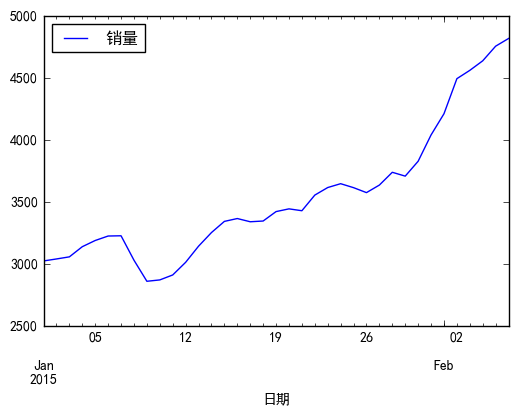

In [3]:
#时序图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
data.plot()
plt.show()

由时序图可以看出，序列有一个明显的上升趋势，所以很可能是非平稳的。

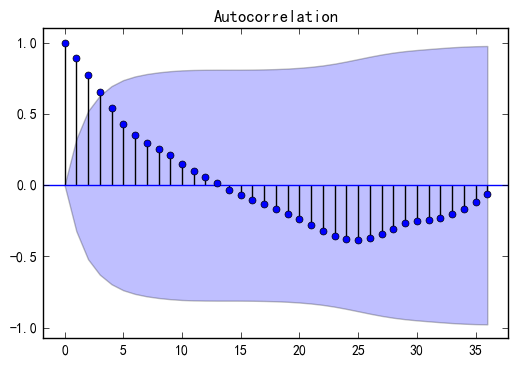

In [8]:
#自相关图
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)

由ACF图可以看出，自相关系数长期大于0，说明序列具有很强的长期相关性

In [9]:
#单位根检测
from statsmodels.tsa.stattools import adfuller as ADF
print(u'原始序列的ADF检验结果为：', ADF(data[u'销量']))
#返回值依次为adf、pvalue、usedlag、nobs、critical values、icbest、regresults、resstore

原始序列的ADF检验结果为： (1.8137710150945272, 0.99837594215142644, 10, 26, {'10%': -2.6300945562130176, '1%': -3.7112123008648155, '5%': -2.9812468047337282}, 299.46989866024177)


单位根检验统计量对应的p值显著大于0.05，不拒绝原假设，认为该序列为非平稳序列

对原始序列进行一阶差分处理

In [10]:
#差分后的结果
D_data = data.diff().dropna()
D_data.columns = [u'销量差分']

然后再次进行平稳性检验

In [13]:
# 时序图
D_data.plot()

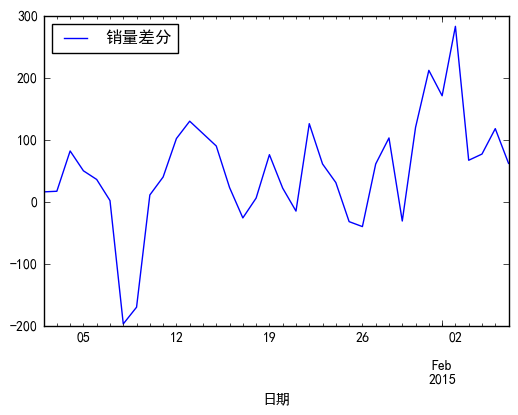

In [14]:
plt.show()

一阶差分后的时序图没有明显的趋势性了。

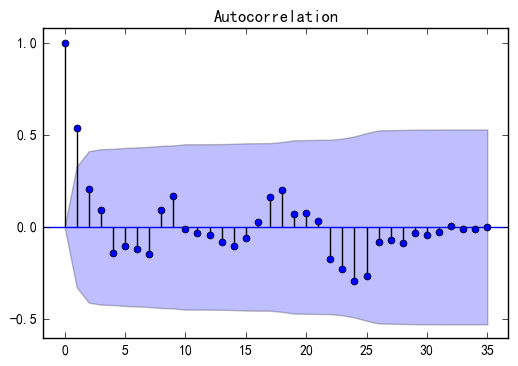

In [15]:
# ACF图
plot_acf(D_data)

In [18]:
# 单位根检验
print('一阶差分后序列的ADF检验结果为：',ADF(D_data['销量差分']))

一阶差分后序列的ADF检验结果为： (-3.1560562366723537, 0.022673435440048798, 0, 35, {'10%': -2.6130173469387756, '1%': -3.6327426647230316, '5%': -2.9485102040816327}, 287.59090907803341)


单位根检验统计量对应的p值显著小于0.05，拒绝原假设，认为该序列非平稳序列

# 2. 白噪声检验  


白噪声检验也称纯随机性检验，一般是构造检验统计量来检验序列的纯随机性，常用的
检验统计量有Q统计量、LB统计量，由样本各延迟期数的自相关系数可以计算得到检验统计
量，然后计算出对应的p值，如果p值显著大于显著性水平α，则表示该序列不能拒绝纯随机
的原假设，可以停止对该序列的分析。

In [21]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(D_data, lags=1)) #返回统计量和p值

差分序列的白噪声检验结果为： (array([ 11.30402222]), array([ 0.00077339]))


输出的p值远小于0.05，所以一阶差分之后的序列是平稳非白噪声序列。

# 3.建模  

ARMA(p,q)模型的全称是自回归移动平均模型，它是目前最常用的拟合平稳序列的模型。
# 1.定阶  
- 1.利用ACF图和PACF图进行ARMA模型的定阶。
- 2.利用BIC定阶

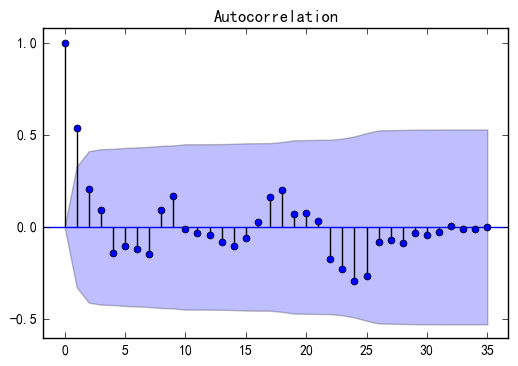

In [20]:
# 利用ACF图和PACF图进行ARMA模型的定阶。
# ACF图
plot_acf(D_data)

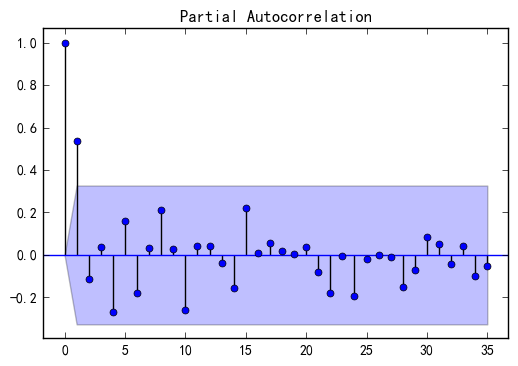

In [17]:
# PACF图
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(D_data)

一阶差分序列的ACF显示出1阶截尾，PACF图显示出1阶截尾，因此考虑p=1,q=1,即对一阶差分序列拟合ARMA(1,1)模型，即对原始序列拟合ARIMA(1,1,1)模型。

In [33]:
import numpy as np
data=np.array(data,dtype=np.float) #转换数据类型，否则arima建模时会报错

# 利用BIC定阶
pmax = int(len(D_data)/10) #一般阶数不超过length/10
qmax = int(len(D_data)/10) #一般阶数不超过length/10
bic_matrix = [] #bic矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try: #存在部分报错，所以用try来跳过报错。
            tmp.append(ARIMA(data, (p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
p,q = bic_matrix.stack().idxmin() #先用stack展平，然后用idxmin找出最小值位置。
print(u'BIC最小的p值和q值为：%s、%s' %(p,q))

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BIC最小的p值和q值为：0、1


BIC原则得出的结论是p选择0，q选择1.确定了p,q之后，接下来的任务就是建模。  


# 2.拟合ARIMA(0,1,1)模型

In [34]:
# 建模
model = ARIMA(data, (p,1,q)).fit() #建立ARIMA(0, 1, 1)模型
model.summary2() #给出一份模型报告

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: ARIMA
=================================================================
Model:              ARIMA            Log-Likelihood:      -205.88
Dependent Variable: D.y              Scale:               1.0000 
Date:               2018-05-24 15:25 Method:              css-mle
No. Observations:   36               Sample:              1      
Df Model:           2                                     7      
Df Residuals:       34               S.D. of innovations: 73.086 
AIC:                417.7595         HQIC:                419.418
BIC:                422.5101                                     
------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
const          49.9557   20.1390  2.4805  0.0182  10.4840  89.4274
ma.L1.D.y       0.6710    0.1648  4.0712  0.0003   0.3480   0.9941
-------------------------------------------------------------------------
                Real          Imaginary         Modulus         Frequency
-------------------------------------------------------------------------
MA.1          -1.4902            0.0000          1.4902            0.5000
=================================================================

"""

# 4.预测

In [35]:
model.forecast(5) #作为期5天的预测，返回预测结果、标准误差、置信区间。

(array([ 4873.96633816,  4923.9220861 ,  4973.87783404,  5023.83358199,
         5073.78932993]),
 array([  73.08574304,  142.32679656,  187.54281698,  223.80281362,
         254.95703671]),
 array([[ 4730.72091401,  5017.21176231],
        [ 4644.96669081,  5202.87748139],
        [ 4606.3006672 ,  5341.45500089],
        [ 4585.18812766,  5462.47903632],
        [ 4574.08272038,  5573.49593948]]))